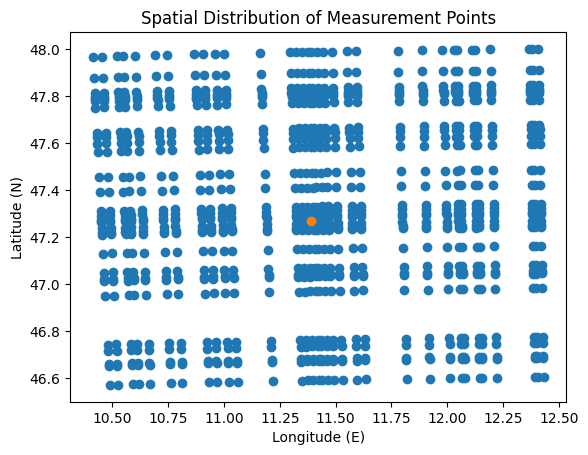

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


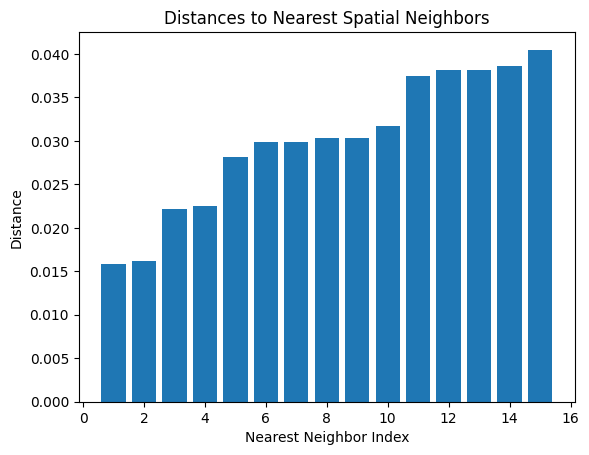

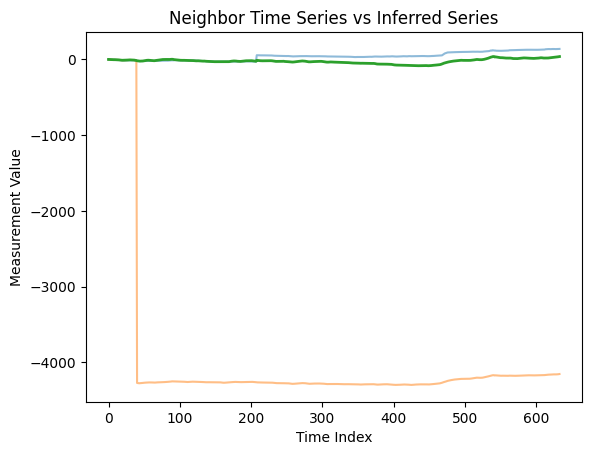

Final submission saved as 67_DreamTeam.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("challenge.csv")

coords = df[["Latitude (N)", "Longitude (E)"]]
values = df.drop(columns=["Latitude (N)", "Longitude (E)"])

target_idx = df.index[-1]
target_coord = coords.loc[target_idx].values.reshape(1, -1)

ref_coords = coords.iloc[:-1]
ref_values = values.iloc[:-1]

# -----------------------------
# Graph 1: Spatial distribution
# -----------------------------
plt.figure()
plt.scatter(ref_coords["Longitude (E)"], ref_coords["Latitude (N)"])
plt.scatter(
    target_coord[0][1],
    target_coord[0][0]
)
plt.xlabel("Longitude (E)")
plt.ylabel("Latitude (N)")
plt.title("Spatial Distribution of Measurement Points")
plt.show()

# -----------------------------
# Spatial KNN
# -----------------------------
k = 15
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")
knn.fit(ref_coords)

distances, indices = knn.kneighbors(target_coord)

neighbor_values = ref_values.iloc[indices[0]]
neighbor_distances = distances[0]

# -----------------------------
# Graph 2: Distances to neighbors
# -----------------------------
plt.figure()
plt.bar(range(1, k + 1), neighbor_distances)
plt.xlabel("Nearest Neighbor Index")
plt.ylabel("Distance")
plt.title("Distances to Nearest Spatial Neighbors")
plt.show()

# -----------------------------
# Distance-weighted median inference
# -----------------------------
weights = 1 / (neighbor_distances + 1e-6)
weights /= weights.sum()

inferred = []

for col in neighbor_values.columns:
    vals = neighbor_values[col].values
    mask = ~np.isnan(vals)

    if mask.sum() == 0:
        inferred.append(np.nan)
        continue

    v = vals[mask]
    w = weights[mask]

    order = np.argsort(v)
    v_sorted = v[order]
    w_sorted = w[order]

    inferred.append(v_sorted[np.cumsum(w_sorted) >= 0.5][0])

inferred_values = pd.Series(inferred, index=neighbor_values.columns)

# -----------------------------
# Graph 3: Time-series comparison
# -----------------------------
plt.figure()
plt.plot(neighbor_values.iloc[0].values, alpha=0.5)
plt.plot(neighbor_values.iloc[1].values, alpha=0.5)
plt.plot(inferred_values.values, linewidth=2)
plt.xlabel("Time Index")
plt.ylabel("Measurement Value")
plt.title("Neighbor Time Series vs Inferred Series")
plt.show()

# -----------------------------
# Clip extreme values
# -----------------------------
lower = ref_values.quantile(0.01)
upper = ref_values.quantile(0.99)
inferred_values = inferred_values.clip(lower=lower, upper=upper)

# -----------------------------
# Save submission
# -----------------------------
submission_row = pd.concat([coords.loc[target_idx], inferred_values])
submission_df = pd.DataFrame([submission_row])

submission_df.to_csv("67_DreamTeam.csv", index=False)

print("Final submission saved as 67_DreamTeam.csv")


In [2]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Load files
challenge = pd.read_csv("challenge.csv")
sub = pd.read_csv("67_DreamTeam.csv")

# Split data
coords = challenge[["Latitude (N)", "Longitude (E)"]]
values = challenge.drop(columns=["Latitude (N)", "Longitude (E)"])

sub_vals = sub.drop(columns=["Latitude (N)", "Longitude (E)"]).iloc[0]

# KNN neighbors
target_coord = coords.iloc[[-1]]  # DataFrame (avoids warning)

knn = NearestNeighbors(n_neighbors=10)
knn.fit(coords.iloc[:-1])

_, idx = knn.kneighbors(target_coord)

neighbor_mean = values.iloc[idx[0]].mean(axis=0)
neighbor_std = values.iloc[idx[0]].std(axis=0)

# Z-score comparison
z_score = ((sub_vals - neighbor_mean) / neighbor_std).abs().mean()

print("Mean Z-score vs neighbors:", z_score)


Mean Z-score vs neighbors: 0.3032490232075018
